## This is the softmax workbook for ECE 239AS Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and code in the jupyer notebook to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training a softmax classifier.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Set the path to the CIFAR-10 data
    import os
    cur_dir = os.getcwd()
    cifar10_dir = cur_dir+'/cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)


    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [3]:
from nndl import Softmax

In [4]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [5]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [6]:
print(loss)

2.3277607028


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this value make sense?

## Answer:

This value makes sense because W is randomly selected and uniform and the therefore the predicted probability of each class is about 1/10. Softmax_i gives you the probabilty that the score of some example in X is i. This probabily is 0.1 for all classes: -log(0.1) = 2.303 which is about the loss we saw. 

#### Softmax gradient

In [7]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: 0.412403 analytic: 0.412403, relative error: 3.446376e-08
numerical: 0.312213 analytic: 0.312213, relative error: 1.052073e-07
numerical: 1.272924 analytic: 1.272924, relative error: 7.471282e-09
numerical: 1.320955 analytic: 1.320955, relative error: 5.032394e-09
numerical: 0.484846 analytic: 0.484846, relative error: 1.075112e-07
numerical: 1.276328 analytic: 1.276328, relative error: 4.069047e-08
numerical: -0.881696 analytic: -0.881696, relative error: 4.674404e-08
numerical: -1.149212 analytic: -1.149212, relative error: 1.691521e-08
numerical: 1.091290 analytic: 1.091290, relative error: 3.474065e-09
numerical: -3.770624 analytic: -3.770625, relative error: 1.175281e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [8]:
import time

In [9]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.301125276726174 / 337.1816978809147 computed in 0.052809953689575195s
Vectorized loss / grad: 2.3011252767261747 / 337.18169788091467 computed in 0.00549769401550293s
difference in loss / grad: -8.881784197001252e-16 /2.1886068313178844e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

## Question:

How should the softmax gradient descent training step differ from the svm training step, if at all?

## Answer:

The step should be the same: theta = theta - learning_rate*grad

iteration 0 / 1500: loss 2.2737199297208335
iteration 100 / 1500: loss 2.0729602283290673
iteration 200 / 1500: loss 1.954150820629599
iteration 300 / 1500: loss 1.961604657081189
iteration 400 / 1500: loss 1.7865491933512971
iteration 500 / 1500: loss 1.8011174931614697
iteration 600 / 1500: loss 1.8308080568092726
iteration 700 / 1500: loss 1.8053062973435983
iteration 800 / 1500: loss 1.8016762229396397
iteration 900 / 1500: loss 1.9632545559113053
iteration 1000 / 1500: loss 1.8388739589408964
iteration 1100 / 1500: loss 1.8601034731196955
iteration 1200 / 1500: loss 1.7995115604923546
iteration 1300 / 1500: loss 1.9278748092064908
iteration 1400 / 1500: loss 1.8584147130537914
That took 2.927264928817749s


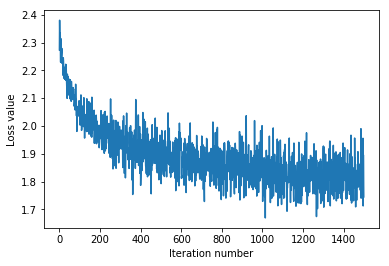

In [14]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [15]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3797142857142857
validation accuracy: 0.382


## Optimize the softmax classifier

You may copy and paste your optimization code from the SVM here.

In [ ]:
np.finfo(float).eps

In [16]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #
learning_rates = [1.0e-1, 1.5e-1, 2.0e-1, 5.0e-1, 1.0e-2, 1.5e-2, 2.0e-2, 1.0e-3, 1.5e-3, 1.5e-4, 1.5e-5]
table = {} #dictionary that has the learning as the key and the validation error as the value.
best_val = -1 #the best validation accuracy we've seen so far
best_clf = None #best Softmax object that gave the above results
best_lr = -1

for lr in learning_rates:
    clf = Softmax()
    loss_hist = clf.train(X_train, y_train, learning_rate = lr, num_iters = 3000)
    y_pred_val = clf.predict(X_val)
    val_accuracy = np.mean(y_pred_val == y_val)
    if(val_accuracy > best_val):
        best_lr = lr
        best_val = val_accuracy
        best_clf = clf
    table[lr] = val_accuracy
    
for lr in sorted(table):
    val_accuracy = table[lr]
    print ("learning rate: %e val accuracy: %f" % (
                lr, val_accuracy))
    
print("Best validation error achieved during cross-validation: %f with learning rate = %f" % (best_val, best_lr))

y_pred_test = best_clf.predict(X_test)
test_accuracy = np.mean(y_test == y_pred_test)
print("Test error using best Softmax object: %f (accuracy is: %f)" % (1-test_accuracy, test_accuracy))
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


/Users/nabeelnauman/Documents/Python/EE239AS/code 2/nndl/softmax.py:153: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(sout[range(num_train), list(y)]))


learning rate: 1.500000e-05 val accuracy: 0.314000
learning rate: 1.500000e-04 val accuracy: 0.278000
learning rate: 1.000000e-03 val accuracy: 0.248000
learning rate: 1.500000e-03 val accuracy: 0.297000
learning rate: 1.000000e-02 val accuracy: 0.326000
learning rate: 1.500000e-02 val accuracy: 0.274000
learning rate: 2.000000e-02 val accuracy: 0.327000
learning rate: 1.000000e-01 val accuracy: 0.314000
learning rate: 1.500000e-01 val accuracy: 0.274000
learning rate: 2.000000e-01 val accuracy: 0.296000
learning rate: 5.000000e-01 val accuracy: 0.244000
Best validation error achieved during cross-validation: 0.327000 with learning rate = 0.020000
Test error using best Softmax object: 0.705000 (accuracy is: 0.295000)
